# Convolutional Neural Networks

Below we will replicate edge detection through the use of filters.

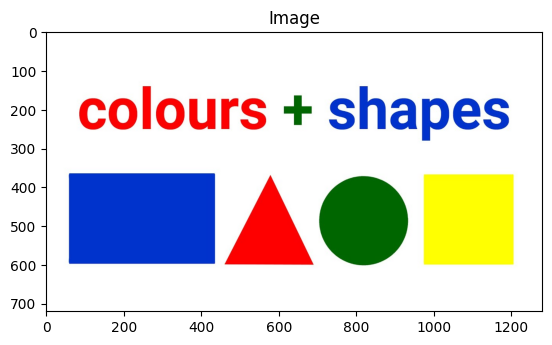

Image Max Value: 255 Image Min Value: 0


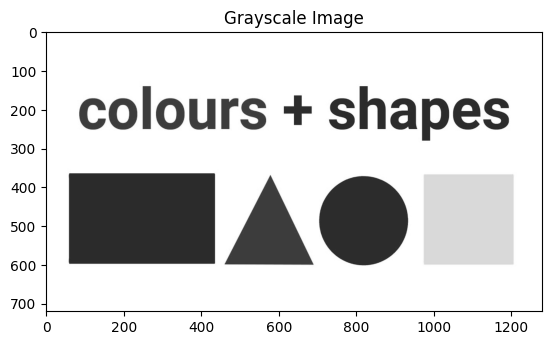

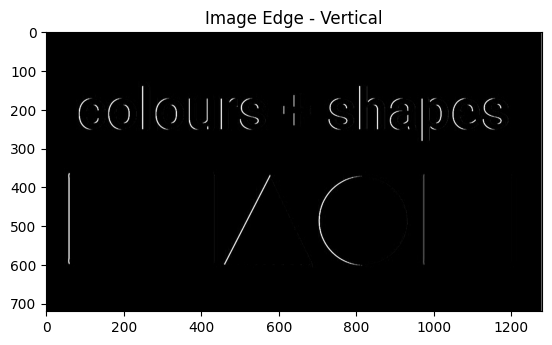

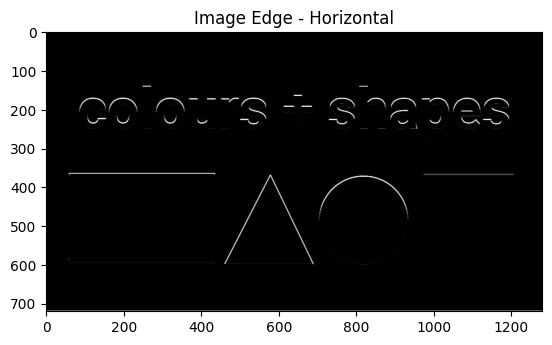

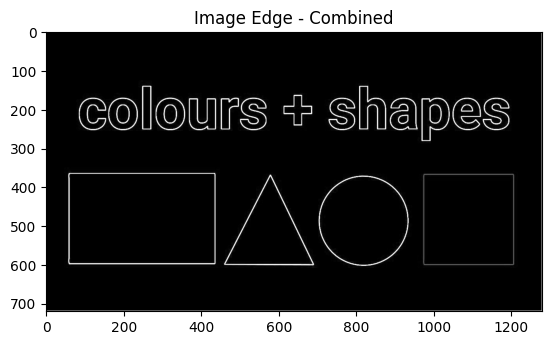

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from PIL import Image
import requests

#load image from the internet
url = 'https://i.ytimg.com/vi/BqKXHIRwGbs/maxresdefault.jpg'
resp = requests.get(url, stream=True).raw
img = Image.open(resp)

#ensure image is np.array
img = np.array(img)

#plot original image
plt.title("Image")
plt.imshow(img)
plt.show()

#increase data precision
img = img.astype(np.int16)
print('Image Max Value:', np.amax(img), 'Image Min Value:', np.amin(img))

#convert from colour to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
  
img_gray = rgb2gray(img)

#plot grayscale image
plt.title("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.show()

#two kernels
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])

#perform 2d convolution
img_edge_x = sg.convolve(img_gray, sobel_x, mode='same')
img_edge_y = sg.convolve(img_gray, sobel_y, mode='same')

#combine images
img_edge = (img_edge_x**2 + img_edge_y**2)**0.5

#correct pixel values
img_edge_x[img_edge_x > 255] = 255
img_edge_x[img_edge_x < 0] = 0

img_edge_y[img_edge_y > 255] = 255
img_edge_y[img_edge_y < 0] = 0

img_edge[img_edge > 255] = 255
img_edge[img_edge < 0] = 0

#return to image format
img_edge_x = img_edge_x.astype(np.uint8)
img_edge_y = img_edge_y.astype(np.uint8)
img_edge = img_edge.astype(np.uint8)

#plot results of convolution in x, and y
plt.title("Image Edge - Vertical")
plt.imshow(img_edge_x, cmap='gray')
plt.show()

plt.title("Image Edge - Horizontal")
plt.imshow(img_edge_y, cmap='gray')
plt.show()

plt.title("Image Edge - Combined")
plt.imshow(img_edge, cmap='gray')
plt.show()


## From ANN to CNN
In the example below you'll see that to go from an ANN to a CNN we only need to make a few changes to our architecture. The rest of the code remains the same.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

### ANN and CNN Architectures
Provided is sample code showing the differences between a basic ANN and CNN architectures. Notice that the CNN architecture also contains fully connected layers.

In [4]:
#variable that allows you to toggle between ANN and CNN architectures
#True => CNN, False => ANN
select_CNN = True

if not select_CNN:
  
  #Artificial Neural Network Architecture (aka MLP)
  class MNISTClassifier(nn.Module):
      def __init__(self):
          super(MNISTClassifier, self).__init__()
          self.fc1 = nn.Linear(28 * 28, 50)
          self.fc2 = nn.Linear(50, 20)
          self.fc3 = nn.Linear(20, 10)  

      def forward(self, img):
          flattened = img.view(-1, 28 * 28)
          activation1 = F.relu(self.fc1(flattened))
          activation2 = F.relu(self.fc2(activation1))
          output = self.fc3(activation2)
          return output
      
      print('Artificial Neural Network Architecture (aka MLP) Selected')
else:

  #Convolutional Neural Network Architecture
  class MNISTClassifier(nn.Module):
      def __init__(self):
          super(MNISTClassifier, self).__init__()
          self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(160, 32)
          self.fc2 = nn.Linear(32, 10)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 160)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x
      
      print('Convolutional Neural Network Architecture Selected')

Convolutional Neural Network Architecture Selected


In [5]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [6]:
def train(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Comparing ANNs and CNNs

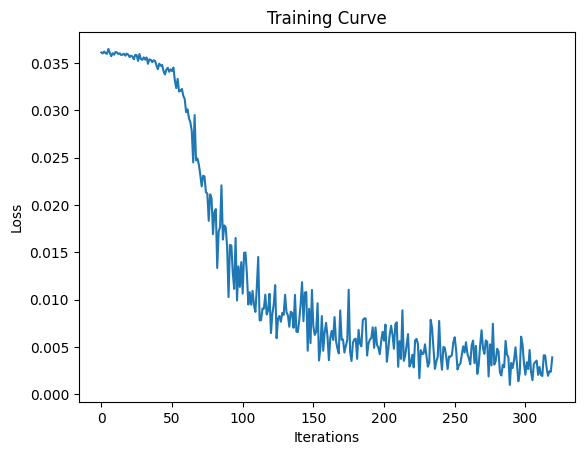

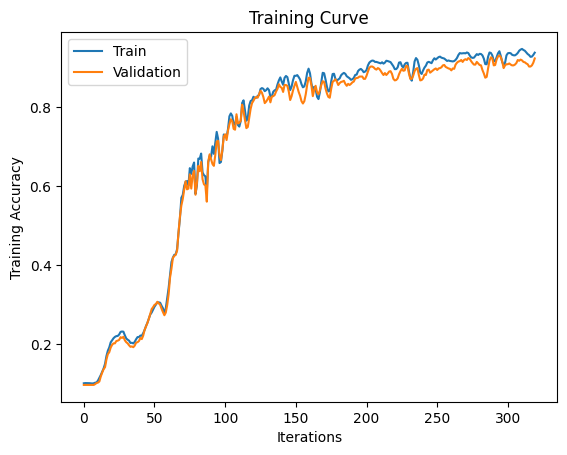

Final Training Accuracy: 0.9384765625
Final Validation Accuracy: 0.923828125


In [7]:
model = MNISTClassifier()

#proper model
train(model, mnist_train, num_epochs=5)

With 5 epochs selected it can take several minutes to train the network. With the power of GPUs we can greatly reduce the time required and put that to tune our hyperparameters to acheive better results.

Label: tensor([4])


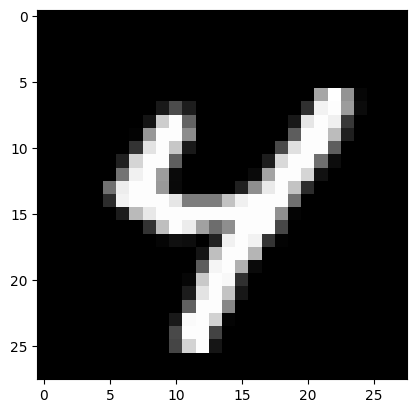

In [68]:
i = 0
for img, label in torch.utils.data.DataLoader(mnist_val, batch_size=1):
    plt.imshow(img.reshape(28,28), cmap='gray')
    i += 1
    if i == 100: 
        print(f'Label: {label}')
        break